In [1]:
import matplotlib.pyplot as plt
import json

In [148]:
with open("data/Toy_SGD_FakeManila.json", "r") as f:
    data = json.load(f)

In [136]:
data

[{'problem': '<problems.toy_benchmark_problem.ToyProblem object at 0x13e4aa490>',
  'n_qubits': 4,
  'cost': 'local',
  'optimizer': 'SGD_lr=5',
  'cond_num': 2,
  'error_threshold': 0.0016,
  'noise_model': None,
  'TTS': 850.4316439628601,
  'STS': 667,
  'final_error': 0.0015997168426719701,
  'cost_history': [0.49935947082620485,
   0.4465162767784628,
   0.02570978464827678,
   0.0257363246994487,
   0.07397188642393587,
   0.1424353798520933,
   0.22537611717910655,
   0.16486467488921525,
   0.12087030517362468,
   0.10389051567432117,
   0.08479223737518155,
   0.056024540894867914,
   0.02208625491714805,
   0.002426996351383437,
   0.00024050909512662866,
   0.0001046238131306998,
   6.74724178161279e-05,
   4.73288757779633e-05,
   3.5053494129744234e-05,
   2.7040966404712208e-05,
   2.1483326332838448e-05,
   1.742706884261258e-05,
   1.4346781554819277e-05,
   1.1938206480710534e-05,
   1.0015170606669788e-05,
   8.457086863811192e-06,
   7.1815190923474326e-06,
   6.1293

In [7]:
TTS = []
STS = []

for trial in data:
    TTS.append(trial["TTS"])
    STS.append(trial["STS"])

Text(0, 0.5, 'Time to solution (s)')

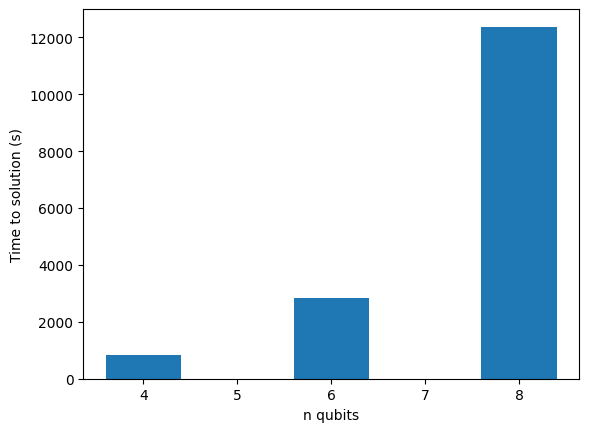

In [12]:
plt.bar([4,6,8], TTS)
plt.xlabel("n qubits")
plt.ylabel("Time to solution (s)")

Text(0, 0.5, 'Steps to solution')

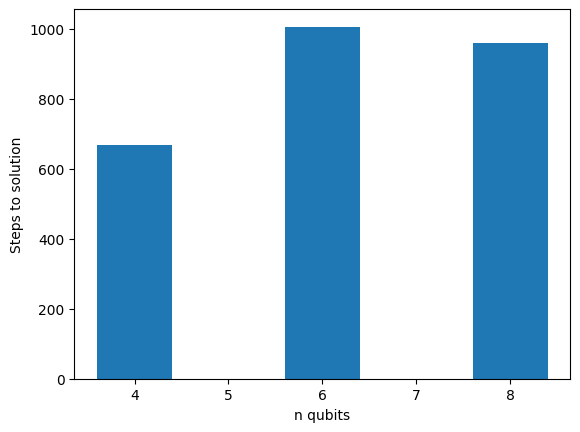

In [13]:
plt.bar([4,6,8], STS)
plt.xlabel("n qubits")
plt.ylabel("Steps to solution")

In [15]:
with open("data/Toy_SGD_Bitflip=0.01.json", "r") as f:
    data2 = json.load(f)

In [17]:
TTS = []
STS = []
final_errors = []
for trial in data2:
    TTS.append((trial["n_qubits"], trial["TTS"]))
    STS.append((trial["n_qubits"], trial["STS"]))
    final_errors.append((trial["n_qubits"], trial["final_error"]))

In [21]:
TTS.sort()
STS.sort()
final_errors.sort()

TTS = [x[1] for x in TTS]
STS = [x[1] for x in STS]
final_errors = [x[1] for x in final_errors]

TTS = [TTS[0], TTS[2], TTS[3]]
STS = [STS[0], STS[2], STS[3]]
final_errors = [final_errors[0], final_errors[2], final_errors[3]]

Text(0, 0.5, 'Time to solution (s)')

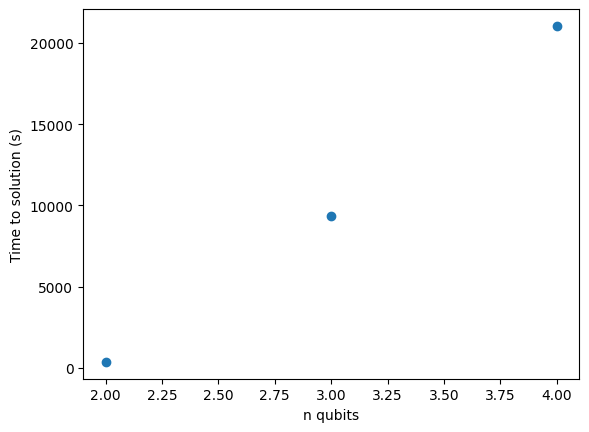

In [23]:
plt.scatter([2,3,4], TTS)
plt.xlabel("n qubits")
plt.ylabel("Time to solution (s)")

Text(0, 0.5, 'Steps to solution')

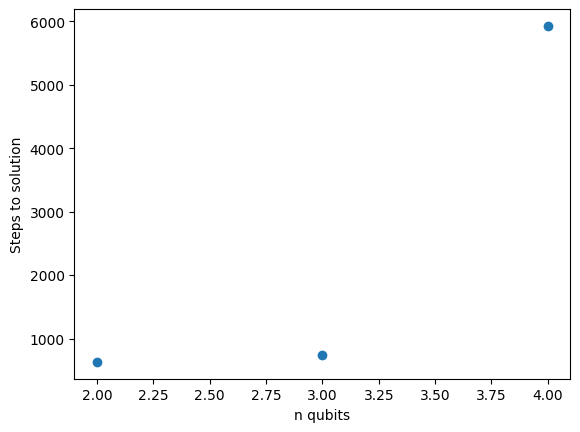

In [24]:
plt.scatter([2,3,4], STS)
plt.xlabel("n qubits")
plt.ylabel("Steps to solution")

Text(0, 0.5, 'Final error achieved')

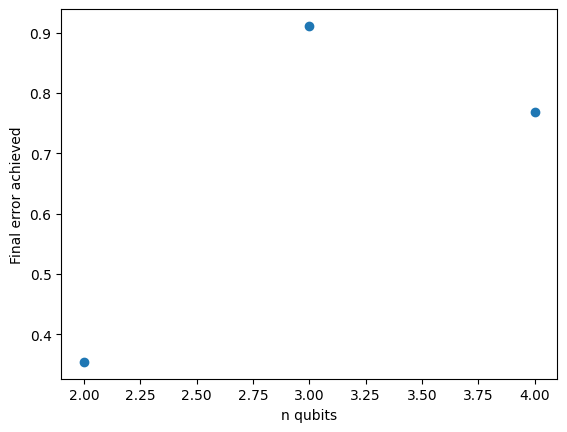

In [25]:
plt.scatter([2,3,4], final_errors)
plt.xlabel("n qubits")
plt.ylabel("Final error achieved")

### Get Final Errors

In [84]:
import pennylane as qml
from pennylane import numpy as np
from problems.toy_benchmark_problem import ToyProblem
from qiskit.providers.fake_provider import *
from bin.hyperparameters import *

In [ ]:
def configured_backend():
    # backend = provider.get_backend("ibm_osaka") # uncomment this line to use a real IBM device
    backend = FakeManila()
    # backend.options.update_options(...)
    return backend

noise_strength = 0.01

['II', 'XX']


/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


ideal sampling: 0.0038590000000000013
noisy sampling: 0.0508015


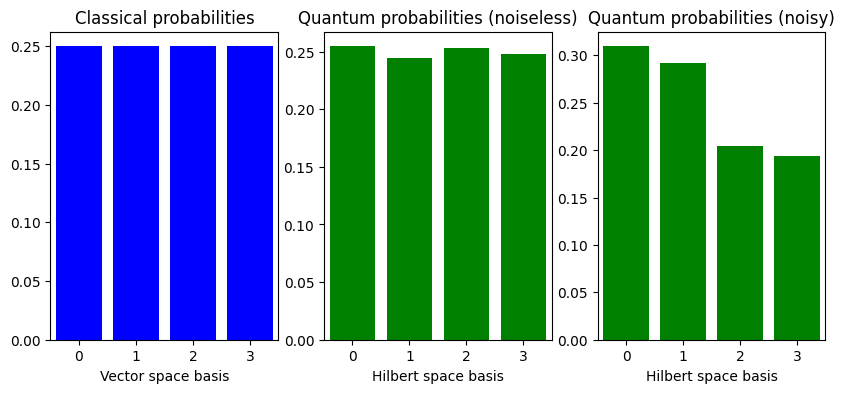

In [149]:
for trial in data:
    # define the problem we want to perform our experiment on
    n_qubits = trial["n_qubits"]
    cond_num = 2

    # problem = IsingProblem(n_qubits=n_qubits, J=0.1, cond_num=cond_num)
    problem = ToyProblem(n_qubits=n_qubits)

    from bin.inference import get_cprobs, get_qprobs
    c_probs = get_cprobs(problem)

    dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

    if trial["noise_model"] == "FakeManila":
        dev_x2 = qml.device("qiskit.remote", wires=n_qubits, backend=configured_backend(), shots=n_shots)
    else:
        dev_x2 = qml.device("default.mixed", wires=n_qubits, shots=n_shots)
        dev_x2 = qml.transforms.insert(
            dev_x2,
            qml.BitFlip,
            noise_strength
        )

    def prepare_and_sample(problem, weights):

        # Variational circuit generating a guess for the solution vector |x>
        problem.variational_block(weights)

        # We assume that the system is measured in the computational basis.
        # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
        # this will be repeated for the total number of shots provided (n_shots)
        return qml.sample()

    def get_qprobs(problem, w, device):
        sampler = qml.QNode(prepare_and_sample, device)

        # sampler = mitigate_node(sampler)

        raw_samples = sampler(problem, w)
        # raw_samples = np.concatenate(raw_samples, axis=0)# FOR BATCHING

        # convert the raw samples (bit strings) into integers and count them
        samples = []
        for sam in raw_samples:
            samples.append(int("".join(str(int(bs)) for bs in sam), base=2))

        q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / len(raw_samples)
        # q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / n_shots

        return q_probs



    q_probs_ideal = get_qprobs(problem, trial["model_weights"], dev_x)
    q_probs_noisy = get_qprobs(problem, trial["model_weights"], dev_x2)
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
    ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
    ax1.set_xlabel("Vector space basis")
    ax1.set_title("Classical probabilities")

    ax2.bar(np.arange(0, 2 ** n_qubits), q_probs_ideal, color="green")
    ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
    ax2.set_xlabel("Hilbert space basis")
    ax2.set_title("Quantum probabilities (noiseless)")

    if trial["noise_model"] is not None:
        ax3.bar(np.arange(0, 2 ** n_qubits), q_probs_noisy, color="green")
        ax3.set_xlim(-0.5, 2 ** n_qubits - 0.5)
        ax3.set_xlabel("Hilbert space basis")
        ax3.set_title("Quantum probabilities (noisy)")

    plt.savefig(f"images/Toy_{trial['optimizer']}_{trial['noise_model']}_n={trial['n_qubits']}.png")

    # calculate expected absolute distance
    ideal_EAD = np.mean(abs(c_probs - q_probs_ideal))
    noisy_EAD = np.mean(abs(c_probs - q_probs_noisy))
    print(f"ideal sampling: {ideal_EAD}")
    print(f"noisy sampling: {noisy_EAD}")

    trial["ideal_EAD"] = ideal_EAD.item()
    trial["noisy_EAD"] = noisy_EAD.item()

    # serialize to JSON?
    import json

    with open(f'processed_data/Toy_{trial["optimizer"]}_{trial["noise_model"]}.json', 'a') as fp:
        fp.write(",")
        json.dump(trial, fp)
